### Prepare the `Taxi` dataset for the pipeline

In [10]:
import pandas as pd
import numpy as np
import random
from shapely.wkt import loads
from shapely.geometry import MultiPolygon, Point

# source 2018 yellow cab taxi rides (112M lines; may sample down to 1M for convenience):
# https://data.cityofnewyork.us/Traasportation/2018-Yellow-Taxi-Trip-Data/t29m-gskq
# source taxi zones:
# https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc
rides_df = pd.read_csv("./taxis.csv", delimiter=";", parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"])
zones_df = pd.read_csv("./taxi_zones.csv")


zones_df = zones_df[["LocationID", "the_geom"]].set_index("LocationID")
rides_df = rides_df.join(zones_df, on="PULocationID")
rides_df = rides_df.join(zones_df, on="DOLocationID", rsuffix="DO")

# remove all non-numeric columns
rides_df.drop(
  columns=["tpep_pickup_datetime", "tpep_dropoff_datetime", "store_and_fwd_flag"],
  inplace=True
)

# only keep rows with a dropoff and a pickup point (i.e., no NaN entries)
rides_df = rides_df[rides_df["the_geom"].notnull() & rides_df["the_geomDO"].notnull()]


# compute a random location inside the polygon until that location actually lies inside the polygon.
# this random location is then used as a representative point for the polygon in the dataset.
def generate_representative(poly: MultiPolygon):
  min_x, min_y, max_x, max_y = poly.bounds
  pos = [-1, -1]
  is_inside = False
  while not is_inside:
    pos[0] = random.uniform(min_x, max_x)
    pos[1] = random.uniform(min_y, max_y)
    is_inside = poly.contains(Point(pos))
  return np.array(pos).reshape(2, 1)


# generate a representative geo point for each taxi ride's pick-up and drop-off location, so that 
# we can linearize by geospace
PUrepresentatives = rides_df.apply(
  lambda row: generate_representative(loads(row["the_geom"])), 
  axis=1
)

# np.stack turns array of objects into array of arrays
PUrepresentatives = np.stack(PUrepresentatives)

DOrepresentatives = rides_df.apply(
  lambda row: generate_representative(loads(row["the_geomDO"])), 
  axis=1
)
DOrepresentatives = np.stack(DOrepresentatives)

# store lat and lng as separate attributes
rides_df["PUrepresentativeX"] = PUrepresentatives[:, 0]
rides_df["PUrepresentativeY"] = PUrepresentatives[:, 1]
rides_df["DOrepresentativeX"] = DOrepresentatives[:, 0]
rides_df["DOrepresentativeY"] = DOrepresentatives[:, 1]

# drop unneeded geometry cols
rides_df.drop(columns=["the_geom", "the_geomDO"], inplace=True)

# write the update data back to the file
rides_df.to_csv("./taxisData.csv", sep=";", index=False, header=False)
rides_df  # takes about 15:30 minutes for 1M 

,tripID,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,PUrepresentativeX,PUrepresentativeY,DOrepresentativeX,DOrepresentativeY
0,31852922,2,2,2.00,1,249,161,1,7.5,0.0,0.5,1.66,0.0,0.3,9.96,-74.001956,40.732820,-73.982600,40.755077
2,66379394,2,2,1.03,1,239,238,2,6.0,0.0,0.5,0.00,0.0,0.3,6.80,-73.974894,40.787301,-73.974943,40.794029
3,10428271,2,1,0.82,1,249,114,1,6.0,0.0,0.5,1.70,0.0,0.3,8.50,-74.001155,40.732384,-73.999961,40.730394
4,23940933,1,2,1.80,1,239,166,1,7.5,0.0,0.5,0.42,0.0,0.3,8.72,-73.976553,40.781925,-73.961674,40.808836
5,49711511,2,1,1.18,1,236,75,1,6.0,0.0,0.5,2.04,0.0,0.3,8.84,-73.962297,40.778530,-73.949639,40.785984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,48567407,2,4,1.90,1,141,142,1,8.5,0.5,0.5,1.96,0.0,0.3,11.76,-73.964472,40.763457,-73.982420,40.771331
999996,67297900,2,6,1.78,1,246,164,2,11.0,0.0,0.5,0.00,0.0,0.3,11.80,-74.009863,40.743692,-73.988661,40.745715
999997,19204703,1,1,0.70,1,162,237,1,6.0,0.0,0.5,2.00,0.0,0.3,8.80,-73.973138,40.755320,-73.967907,40.763041
999998,53762823,4,1,0.84,1,249,125,1,5.5,0.0,0.5,1.26,0.0,0.3,7.56,-73.998919,40.734828,-74.005231,40.727299


### Precompute linearizations

In [103]:
import pandas as pd
import sys
import os

sys.path.append(f"{os.getcwd()}/../../../")  # HACK to make relative imports work in notebooks

from pipeline.linearizations.Linearization import LinearizationDatetimeAttr, LinearizationNumericAttr, LinearizationGeoZorder

# lin1 = LinearizationDatetimeAttr("taxis", 20, 2)  # sort by pickup date
# lin1_data = lin1.linearize()

lin2 = LinearizationNumericAttr("taxis", 20, 3)  # sort by trip distance
lin2_data = lin2.linearize()

lin3 = LinearizationGeoZorder("taxis", 20, 15, 16)  # sort by pickup location
lin3_data = lin3.linearize()

Linearized file into folder output_files
Linearized file into folder output_files


In [136]:
rides_df.describe().loc[["min", "max"]]

,index,tripID,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,PUrepresentativeX,PUrepresentativeY,DOrepresentativeX,DOrepresentativeY
min,0.0,73.0,1.0,0.0,0.01,1.0,1.0,1.0,1.0,0.01,-0.49,0.0,0.0,0.0,0.0,0.31,-74.190861,40.542776,-74.237539,40.520042
max,999999.0,76955200.0,4.0,9.0,63.30,99.0,263.0,263.0,4.0,398.00,17.50,0.5,300.0,950.7,0.3,1003.50,-73.715146,40.900405,-73.714274,40.900818


<AxesSubplot:xlabel='PUrepresentativeX'>

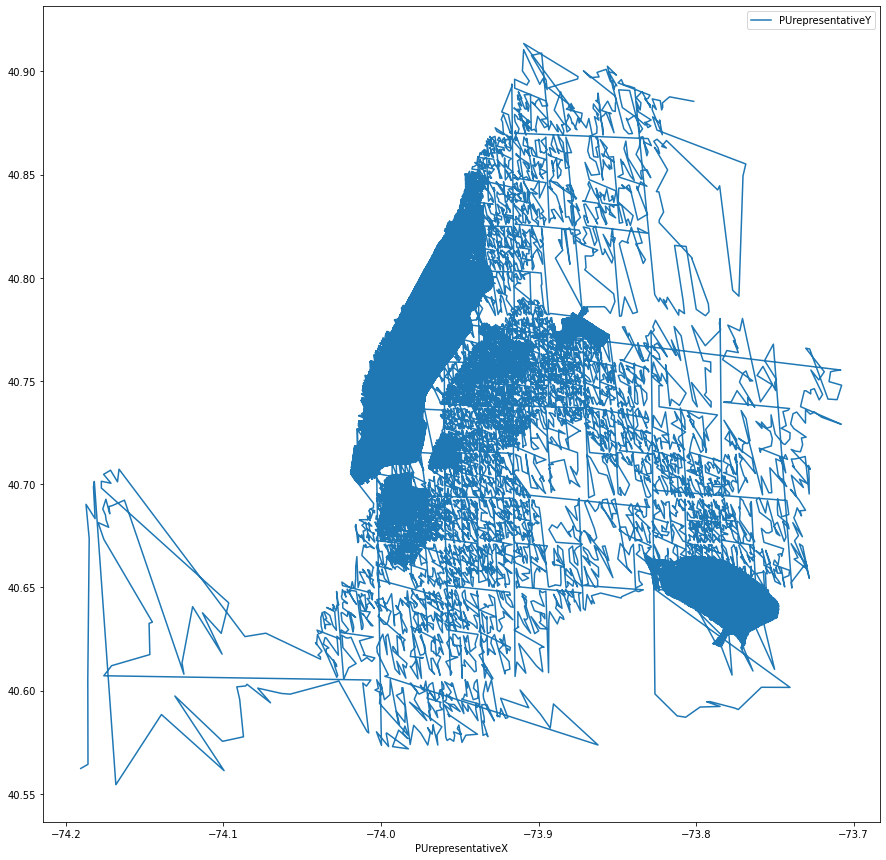

In [108]:
import pandas as pd

columns = ["tripID", "VendorID", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "PUrepresentativeX", "PUrepresentativeY", "DOrepresentativeX", "DOrepresentativeY"]
df = pd.read_csv("../../linearization_files/taxisLinearizationGeoZorder.csv", delimiter=";", names=columns)

df.plot.line(x="PUrepresentativeX", y="PUrepresentativeY", figsize=[15, 15])
# df